<a href="https://colab.research.google.com/github/sleepyMS/Transformer-chatbot/blob/main/%EA%B8%B0%EA%B3%84%ED%95%99%EC%8A%B5_%EC%B5%9C%EC%A2%85%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# train_and_save_model.py

# -*- coding: utf-8 -*-
"""Train and Save Transformer Chatbot Model

This script trains a Transformer-based chatbot model using the provided dataset and saves the trained model and tokenizer for future use.
"""

# 필요한 라이브러리 설치 및 임포트
!pip install konlpy
!pip install git+https://github.com/ssut/py-hanspell.git

import tensorflow as tf
import numpy as np
import pandas as pd
import re
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from hanspell import spell_checker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 30.0 MB/s eta 0:00:00
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-gtedg644
  Running command git clone --filter=blob:none --quiet https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-gtedg644
  Resolved https://github.com/ssut/py-hanspell.git to commit fdc6ca50c19f1c85971437a072d89d4e5ce024b8
  Preparing metadata (setup.py) ... done
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4810 sha256=cb77860e1961196fcf3f84ae8af5bb6b9c9222c52147cd2cc623cce04127c0a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-_byuk9ut/wheels/2e/43/cc/753c9e1d91affb9ea40e186cea5654fb9231deb454da6724e5
Successfully built py-hanspell


In [ ]:


# 데이터 로드 및 전처리
data = pd.read_csv('최종_데이터.csv').dropna()

# 형태소 분석기 객체 생성
okt = Okt()

# 문장 전처리 함수 정의
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z0-9?.!,/]+", " ", sentence)  # '/'를 유지
    sentence = sentence.strip()
    return sentence

# 형태소 분석 및 품사 태깅 함수 정의
def tokenize_sentence(sentence):
    return okt.pos(sentence)

# 토큰 및 품사 태그를 사용하여 문장 복원 함수 정의
def reconstruct_sentence(pos_tokens):
    sentence = ''
    for word, pos in pos_tokens:
        if pos in ['Josa', 'Suffix', 'Eomi', 'Punctuation']:
            sentence = sentence.rstrip() + word  # 앞 공백 제거하고 붙임
        else:
            sentence += word + ' '
    return sentence.strip()

# 질문과 답변 리스트 생성
questions = []
answers = []

for context, q, a in zip(data['Context'], data['Q'], data['A']):
    conversation = []
    if pd.isnull(context) or context == '':
        conversation.append('<usr> ' + reconstruct_sentence(tokenize_sentence(preprocess_sentence(q))))
    else:
        exchanges = context.split(' / ')
        for i, exchange in enumerate(exchanges):
            if i % 2 == 0:
                conversation.append('<usr> ' + reconstruct_sentence(tokenize_sentence(preprocess_sentence(exchange))))
            else:
                conversation.append('<sys> ' + reconstruct_sentence(tokenize_sentence(preprocess_sentence(exchange))))
        conversation.append('<usr> ' + reconstruct_sentence(tokenize_sentence(preprocess_sentence(q))))
    combined_q = ' '.join(conversation)
    questions.append(combined_q)
    answers.append('<sys> ' + reconstruct_sentence(tokenize_sentence(preprocess_sentence(a))) + ' <end>')

# 데이터셋 분할 (훈련 세트와 테스트 세트)
train_q, test_q, train_a, test_a = train_test_split(
    questions, answers, test_size=0.2, random_state=42)

# 토크나이저 생성 및 단어 사전 구축 (훈련 데이터에만 적용)
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<unk>')
tokenizer.fit_on_texts(train_q + train_a)

# 시퀀스로 변환
train_q_seq = tokenizer.texts_to_sequences(train_q)
train_a_seq = tokenizer.texts_to_sequences(train_a)
test_q_seq = tokenizer.texts_to_sequences(test_q)
test_a_seq = tokenizer.texts_to_sequences(test_a)

# 시퀀스 패딩
MAX_LENGTH = 60

train_q_seq = tf.keras.preprocessing.sequence.pad_sequences(
    train_q_seq, maxlen=MAX_LENGTH, padding='post')
train_a_seq = tf.keras.preprocessing.sequence.pad_sequences(
    train_a_seq, maxlen=MAX_LENGTH, padding='post')
test_q_seq = tf.keras.preprocessing.sequence.pad_sequences(
    test_q_seq, maxlen=MAX_LENGTH, padding='post')
test_a_seq = tf.keras.preprocessing.sequence.pad_sequences(
    test_a_seq, maxlen=MAX_LENGTH, padding='post')

# 디코더 입력과 출력 생성
train_decoder_inputs = train_a_seq[:, :-1]
train_decoder_outputs = train_a_seq[:, 1:]
test_decoder_inputs = test_a_seq[:, :-1]
test_decoder_outputs = test_a_seq[:, 1:]

# 훈련 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_q_seq,
        'dec_inputs': train_decoder_inputs
    },
    train_decoder_outputs
))

BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(len(train_q_seq))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 테스트 데이터셋 생성
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': test_q_seq,
        'dec_inputs': test_decoder_inputs
    },
    test_decoder_outputs
))

test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 단어 사전 크기 설정
vocab_size = len(tokenizer.word_index) + 1

# 포지셔널 인코딩 함수 정의
def get_angles(pos, i, d_model):
    angles = 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))
    return pos * angles

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # 짝수 인덱스: 사인 함수
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 홀수 인덱스: 코사인 함수
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

# 마스킹 함수 정의
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # (batch_size, 1, 1, seq_len)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(seq):
    seq_len = tf.shape(seq)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(seq)
    return tf.maximum(look_ahead_mask, padding_mask)

# 스케일드 닷 프로덕트 어텐션 함수 정의
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # 스케일링
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 마스킹
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # 소프트맥스
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

# 멀티헤드 어텐션 클래스 정의
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)

        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // num_heads

        self.wq = tf.keras.layers.Dense(d_model)  # 쿼리 가중치
        self.wk = tf.keras.layers.Dense(d_model)  # 키 가중치
        self.wv = tf.keras.layers.Dense(d_model)  # 값 가중치

        self.dense = tf.keras.layers.Dense(d_model)  # 출력 가중치

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
        })
        return config

    def split_heads(self, x, batch_size):
        # 마지막 차원을 (num_heads, depth)로 분할
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        # 선형 변환
        q = self.wq(q)  # (batch_size, seq_len_q, d_model)
        k = self.wk(k)  # (batch_size, seq_len_k, d_model)
        v = self.wv(v)  # (batch_size, seq_len_v, d_model)

        # 헤드 분할
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # 어텐션 계산
        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)

        # 헤드 결합
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        # 출력 레이어
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output

# 포지션 와이즈 피드 포워드 네트워크
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

# 인코더 레이어 정의
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)

        self.mha = MultiHeadAttention(d_model, num_heads)  # 멀티헤드 어텐션
        self.ffn = point_wise_feed_forward_network(d_model, dff)  # 포지션 와이즈 FFN

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # 레이어 정규화
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)  # 드롭아웃
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.dropout_rate = dropout_rate

    def get_config(self):
        config = super(EncoderLayer, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'dropout_rate': self.dropout_rate,
        })
        return config

    def call(self, x, training=None, mask=None):
        attn_output = self.mha(x, x, x, mask)  # 멀티헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)  # 드롭아웃
        out1 = self.layernorm1(x + attn_output)  # 잔차 연결과 레이어 정규화

        ffn_output = self.ffn(out1)  # 포지션 와이즈 FFN
        ffn_output = self.dropout2(ffn_output, training=training)  # 드롭아웃
        out2 = self.layernorm2(out1 + ffn_output)  # 잔차 연결과 레이어 정규화

        return out2

# 인코더 정의
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding, dropout_rate=0.1, **kwargs):
        super(Encoder, self).__init__(**kwargs)

        self.d_model = d_model
        self.num_layers = num_layers

        # 임베딩 레이어와 포지셔널 인코딩
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        # 인코더 레이어
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.input_vocab_size = input_vocab_size
        self.maximum_position_encoding = maximum_position_encoding
        self.dropout_rate = dropout_rate

    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'input_vocab_size': self.input_vocab_size,
            'maximum_position_encoding': self.maximum_position_encoding,
            'dropout_rate': self.dropout_rate,
        })
        return config

    def call(self, x, training=None, mask=None):
        seq_len = tf.shape(x)[1]

        # 임베딩과 포지셔널 인코딩
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # 인코더 레이어 통과
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x  # (batch_size, input_seq_len, d_model)

# 디코더 레이어 정의
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)

        self.mha1 = MultiHeadAttention(d_model, num_heads)  # 마스크드 멀티헤드 어텐션
        self.mha2 = MultiHeadAttention(d_model, num_heads)  # 인코더-디코더 어텐션

        self.ffn = point_wise_feed_forward_network(d_model, dff)  # 포지션 와이즈 FFN

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # 레이어 정규화
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)  # 드롭아웃
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)

        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.dropout_rate = dropout_rate

    def get_config(self):
        config = super(DecoderLayer, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'dropout_rate': self.dropout_rate,
        })
        return config

    def call(self, x, enc_output, training=None,
             look_ahead_mask=None, padding_mask=None):
        attn1 = self.mha1(x, x, x, look_ahead_mask)  # 마스크드 멀티헤드 어텐션
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)  # 잔차 연결과 레이어 정규화

        attn2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # 인코더-디코더 어텐션
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)  # 잔차 연결과 레이어 정규화

        ffn_output = self.ffn(out2)  # 포지션 와이즈 FFN
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)  # 잔차 연결과 레이어 정규화

        return out3

# 디코더 정의
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 target_vocab_size, maximum_position_encoding, dropout_rate=0.1, **kwargs):
        super(Decoder, self).__init__(**kwargs)

        self.d_model = d_model
        self.num_layers = num_layers

        # 임베딩 레이어와 포지셔널 인코딩
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        # 디코더 레이어
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, dropout_rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.target_vocab_size = target_vocab_size
        self.maximum_position_encoding = maximum_position_encoding
        self.dropout_rate = dropout_rate

    def get_config(self):
        config = super(Decoder, self).get_config()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'target_vocab_size': self.target_vocab_size,
            'maximum_position_encoding': self.maximum_position_encoding,
            'dropout_rate': self.dropout_rate,
        })
        return config

    def call(self, x, enc_output, training=None,
             look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]

        # 임베딩과 포지셔널 인코딩
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # 디코더 레이어 통과
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training=training,
                                   look_ahead_mask=look_ahead_mask,
                                   padding_mask=padding_mask)

        return x  # (batch_size, target_seq_len, d_model)

# 트랜스포머 모델 정의
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 vocab_size, pe_input, pe_target, dropout_rate=0.1, **kwargs):
        super(Transformer, self).__init__(**kwargs)

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               vocab_size, pe_input, dropout_rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               vocab_size, pe_target, dropout_rate)

        self.final_layer = tf.keras.layers.Dense(vocab_size)

        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.vocab_size = vocab_size
        self.pe_input = pe_input
        self.pe_target = pe_target
        self.dropout_rate = dropout_rate

    def get_config(self):
        config = super(Transformer, self).get_config()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'vocab_size': self.vocab_size,
            'pe_input': self.pe_input,
            'pe_target': self.pe_target,
            'dropout_rate': self.dropout_rate,
        })
        return config

    def call(self, inputs, training=None):
        enc_input = inputs['inputs']
        dec_input = inputs['dec_inputs']

        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(enc_input, dec_input)

        # 인코더 출력
        enc_output = self.encoder(enc_input, training=training, mask=enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # 디코더 출력
        dec_output = self.decoder(dec_input, enc_output, training=training,
                                  look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)  # (batch_size, tar_seq_len, d_model)

        # 최종 출력
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, vocab_size)

        return final_output

    def create_masks(self, enc_input, dec_input):
        # 인코더 패딩 마스크
        enc_padding_mask = create_padding_mask(enc_input)

        # 디코더 패딩 마스크
        dec_padding_mask = create_padding_mask(enc_input)

        # 룩어헤드 마스크
        look_ahead_mask = create_look_ahead_mask(dec_input)
        dec_target_padding_mask = create_padding_mask(dec_input)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, combined_mask, dec_padding_mask

# 하이퍼파라미터 설정
num_layers = 4
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.1

# 모델 생성
model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    vocab_size=vocab_size,
    pe_input=1000,
    pe_target=1000,
    dropout_rate=dropout_rate)

# 손실 함수 및 옵티마이저 설정
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, tf.shape(y_true)[-1]))
    loss_ = loss_object(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss_function)

# 콜백 함수 설정 (훈련 손실을 저장하기 위해)
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))

history_callback = LossHistory()




In [ ]:

# 모델 학습
EPOCHS = 100  # 필요한 경우 에포크 수 조정
history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[history_callback])

Epoch 1/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 241s 412ms/step - loss: 11.4717
Epoch 2/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 125s 322ms/step - loss: 9.2231
Epoch 3/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 120s 322ms/step - loss: 9.0065
Epoch 4/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 323ms/step - loss: 8.7784
Epoch 5/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 324ms/step - loss: 8.5643
Epoch 6/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 324ms/step - loss: 8.3606
Epoch 7/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 121s 323ms/step - loss: 8.1661
Epoch 8/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 121s 323ms/step - loss: 7.9920
Epoch 9/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 121s 324ms/step - loss: 7.8195
Epoch 10/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 325ms/step - loss: 7.6521
Epoch 11/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 325ms/step - loss: 7.4659
Epoch 12/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 121s 324ms/step - loss: 7.3010
Epoch 13/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 121s 324ms/step - loss: 7.1513
Epoch 14/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 143s 326ms/step -

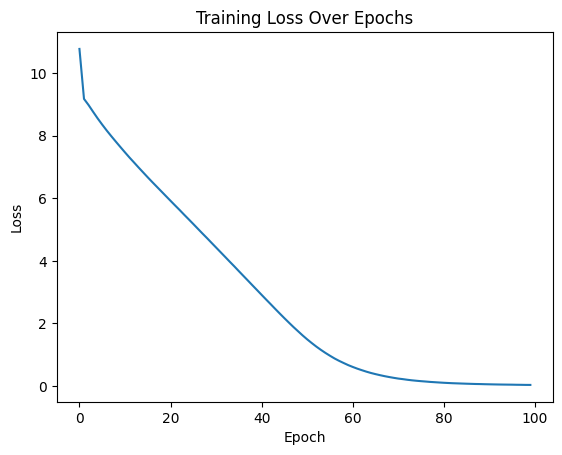

In [ ]:

# 모델 저장 (SavedModel 형식으로 저장)
model.save('transformer_chatbot_model.keras')

# 토크나이저 저장
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 훈련 손실 시각화
plt.plot(history_callback.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()